# exp001: OR-toolsによるVRPソルバー実装（F-n135-k7）

Google OR-toolsを使用してF-n135-k7インスタンス（135ノード、7車両）のVRPを解く
距離計算でDecimal.quantize(ROUND_HALF_UP)を使用し、TSPLIBの標準に準拠

In [1]:
import sys
import os
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from utils import VRPDataReader, read_solution

## 1. 設定ファイルの読み込み

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("設定内容:")
print(yaml.dump(config, default_flow_style=False))

設定内容:
experiment:
  description: "OR-toolsVRP\u30BD\u30EB\u30D0\u30FC\uFF08Decimal.quantize()\u7248\u3001\
    F-n135-k7\u30A4\u30F3\u30B9\u30BF\u30F3\u30B9\uFF09"
  experiment_id: exp002
paths:
  output_dir: ../../results
  sol_file: ../../data/f-n135-k7.sol
  vrp_file: ../../data/f-n135-k7.vrp
solver:
  first_solution_strategy: PATH_CHEAPEST_ARC
  local_search_metaheuristic: GUIDED_LOCAL_SEARCH
  solution_limit: 100
  time_limit_seconds: 120



## 2. VRPデータの読み込み

In [3]:
vrp_reader = VRPDataReader(config['paths']['vrp_file'])
vrp_data = vrp_reader.parse()

print(f"インスタンス名: {vrp_data['name']}")
print(f"ノード数: {vrp_data['dimension']}")
print(f"車両数: {vrp_data['num_vehicles']}")
print(f"車両容量: {vrp_data['capacity']}")
print(f"最適値: {vrp_data['optimal_value']}")

インスタンス名: F-n135-k7
ノード数: 135
車両数: 7
車両容量: 2210
最適値: 1162.0


In [4]:
distance_matrix = vrp_reader.compute_distance_matrix()
print(f"距離行列のサイズ: {distance_matrix.shape}")
print(f"最大距離: {np.max(distance_matrix)}")
print(f"最小距離（非ゼロ）: {np.min(distance_matrix[distance_matrix > 0])}")

距離行列のサイズ: (135, 135)
最大距離: 186.0
最小距離（非ゼロ）: 1.0


In [5]:
optimal_routes, optimal_cost = read_solution(config['paths']['sol_file'])
print(f"最適解のコスト: {optimal_cost}")
print(f"最適解のルート数: {len(optimal_routes)}")
for i, route in enumerate(optimal_routes, 1):
    print(f"  ルート{i}: {len(route)}ノード")

最適解のコスト: 1162.0
最適解のルート数: 7
  ルート1: 7ノード
  ルート2: 12ノード
  ルート3: 13ノード
  ルート4: 41ノード
  ルート5: 26ノード
  ルート6: 19ノード
  ルート7: 16ノード


## 3. OR-toolsのデータモデル作成

In [6]:
def create_data_model():
    data = {}
    data['distance_matrix'] = distance_matrix.astype(int).tolist()
    data['demands'] = [vrp_data['demands'].get(i, 0) for i in range(1, vrp_data['dimension'] + 1)]
    data['vehicle_capacities'] = [vrp_data['capacity']] * vrp_data['num_vehicles']
    data['num_vehicles'] = vrp_data['num_vehicles']
    data['depot'] = 0
    return data

data = create_data_model()
print(f"データモデル作成完了")
print(f"需要量の合計: {sum(data['demands'])}")
print(f"総容量: {sum(data['vehicle_capacities'])}")

データモデル作成完了
需要量の合計: 14620
総容量: 15470


## 4. VRPソルバーの実装

In [7]:
def print_solution(data, manager, routing, solution):
    total_distance = 0
    total_load = 0
    routes = []
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        route_distance = 0
        route_load = 0
        
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index + 1)  # 1-indexed
            route_load += data['demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        
        if len(route) > 1:  # デポのみのルートは除外
            routes.append(route[1:])  # デポを除外
            print(f"ルート {vehicle_id + 1}: {route[1:]}")
            print(f"  距離: {route_distance}, 積載量: {route_load}")
            total_distance += route_distance
            total_load += route_load
    
    print(f"\n総距離: {total_distance}")
    print(f"総積載量: {total_load}")
    
    return routes, total_distance

In [8]:
def solve_vrp():
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot']
    )
    
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],
        True,  # start cumul to zero
        'Capacity'
    )
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.seconds = config['solver']['time_limit_seconds']
    
    print("ソルバー実行中...")
    start_time = time.time()
    solution = routing.SolveWithParameters(search_parameters)
    solve_time = time.time() - start_time
    
    if solution:
        print(f"\n解が見つかりました（計算時間: {solve_time:.2f}秒）")
        routes, total_distance = print_solution(data, manager, routing, solution)
        return routes, total_distance, solve_time
    else:
        print("解が見つかりませんでした")
        return None, None, solve_time

In [9]:
routes, total_distance, solve_time = solve_vrp()

ソルバー実行中...



解が見つかりました（計算時間: 120.00秒）
ルート 1: [82, 111, 123, 122, 110, 109, 108, 107, 115, 116, 19, 119]
  距離: 336, 積載量: 2146
ルート 2: [18, 133, 114, 127, 113, 126, 124, 70, 71, 69, 68, 80, 64, 65]
  距離: 205, 積載量: 2207
ルート 3: [67, 72, 47, 83, 21, 84, 86, 85, 87, 88, 90, 91, 28, 26, 22, 92]
  距離: 138, 積載量: 1829
ルート 4: [20, 66, 131, 120, 118, 117, 132, 121, 130, 129, 128, 125, 112]
  距離: 281, 積載量: 2197
ルート 5: [23, 25, 27, 29, 30, 93, 17, 14, 16, 89, 15, 13, 12, 11, 10, 9, 8, 7, 6, 5, 3, 43, 42, 4, 41, 45, 44, 40, 39, 97, 98, 99, 101, 102, 103, 104, 55, 51, 50, 49, 35, 33, 77, 75, 74]
  距離: 121, 積載量: 2083
ルート 6: [61, 60, 59, 94, 95, 46, 96, 38, 37, 36, 100, 105, 57, 106, 58, 56, 54, 52, 53, 63, 62, 2, 48, 73]
  距離: 65, 積載量: 2153
ルート 7: [24, 31, 32, 76, 135, 78, 79, 134, 34, 81]
  距離: 98, 積載量: 2005

総距離: 1244
総積載量: 14620


## 5. 結果の可視化

In [10]:
def plot_routes(routes, vrp_data, title="VRP Solution"):
    plt.figure(figsize=(12, 8))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    depot_x, depot_y = vrp_data['node_coords'][1]
    plt.scatter(depot_x, depot_y, c='black', s=200, marker='s', label='Depot', zorder=5)
    
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        
        prev_x, prev_y = depot_x, depot_y
        
        for node in route:
            x, y = vrp_data['node_coords'][node]
            plt.scatter(x, y, c=color, s=100, zorder=4)
            plt.arrow(prev_x, prev_y, x - prev_x, y - prev_y,
                     head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
            plt.text(x, y, str(node), fontsize=8, ha='center', va='bottom')
            prev_x, prev_y = x, y
        
        plt.arrow(prev_x, prev_y, depot_x - prev_x, depot_y - prev_y,
                 head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6,
                 label=f'Route {i+1}')
    
    plt.xlabel('X座標')
    plt.ylabel('Y座標')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_62734/2092790511.py:31: UserWarning: Glyph 24231 (\N{CJK UNIFIED IDEOGRAPH-5EA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_62734/2092790511.py:31: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24231 (\N{CJK UNIFIED IDEOGRAPH-5EA7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


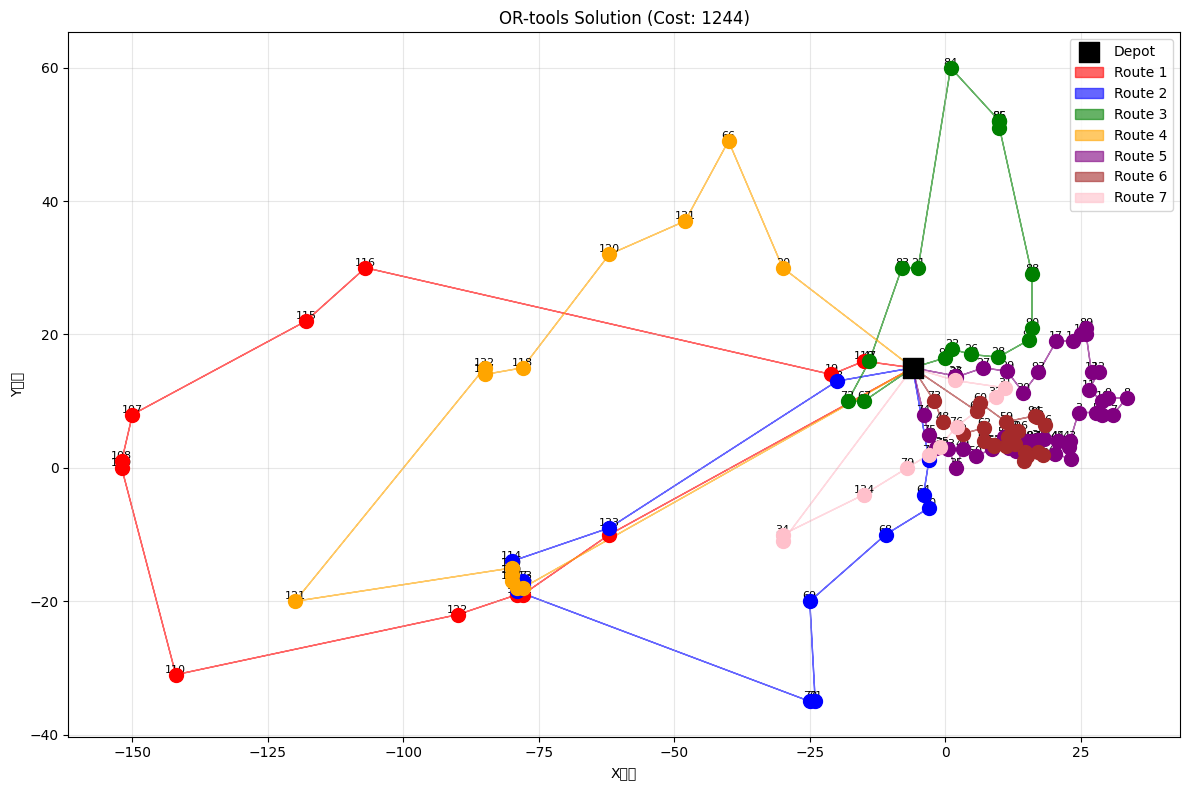

In [11]:
if routes:
    plot_routes(routes, vrp_data, f"OR-tools Solution (Cost: {total_distance})")

## 6. 最適解との比較

In [12]:
if routes:
    print("=" * 50)
    print("結果の比較")
    print("=" * 50)
    print(f"最適解のコスト: {optimal_cost}")
    print(f"OR-toolsのコスト: {total_distance}")
    print(f"差: {total_distance - optimal_cost}")
    print(f"最適解との比率: {(total_distance / optimal_cost * 100):.2f}%")
    print(f"計算時間: {solve_time:.2f}秒")
    
    gap = (total_distance - optimal_cost) / optimal_cost * 100
    print(f"\n最適性ギャップ: {gap:.2f}%")

結果の比較
最適解のコスト: 1162.0
OR-toolsのコスト: 1244
差: 82.0
最適解との比率: 107.06%
計算時間: 120.00秒

最適性ギャップ: 7.06%


In [13]:
import json
import os

results = {
    'experiment_id': config['experiment']['experiment_id'],
    'instance': vrp_data['name'],
    'optimal_cost': optimal_cost,
    'solution_cost': total_distance,
    'gap_percentage': gap if routes else None,
    'solve_time_seconds': solve_time,
    'num_routes': len(routes) if routes else None,
    'solver_settings': config['solver']
}

os.makedirs(config['paths']['output_dir'], exist_ok=True)
results_path = os.path.join(config['paths']['output_dir'], 'exp001_results.json')

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n結果を保存しました: {results_path}")


結果を保存しました: ../../results/exp001_results.json
